
In this project, we build a complete local volatility model using the Dupire equation.
We begin by generating synthetic market option prices using a known implied volatility function.
We then extract the local volatility surface using the Dupire forward PDE
where C(K, T) is the market call price as a function of strike K and maturity T.

After extracting the surface, we:
- Visualize the local volatility surface
- Simulate paths under local volatility using Monte Carlo
- Price exotic options such as barrier and Asian options
- Compare hedging performance using Black-Scholes and local volatility
- Simulate stochastic volatility (Heston model) to observe volatility clustering

We conclude by comparing the dynamic properties of local and stochastic volatility models in capturing implied volatilities and clustering behavior.


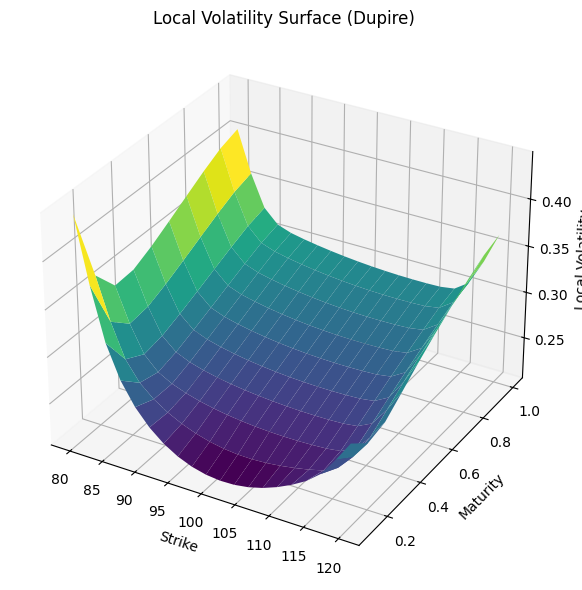

Barrier Option Price (Local Vol): 1.9631
Asian Option Price (Local Vol): 3.5717
Avg Hedging PnL (Black-Scholes Delta): -6.7901
Avg Hedging PnL (Local Vol Delta approx): -6.7901


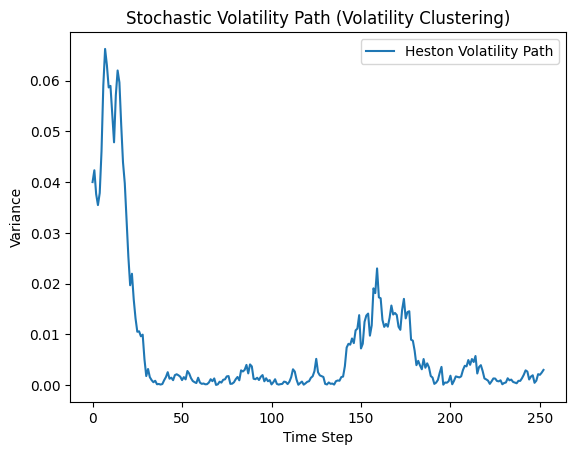

Local volatility surface saved as 'local_vol_surface.csv'


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.stats import norm
from scipy.ndimage import gaussian_filter
from mpl_toolkits.mplot3d import Axes3D

# -----------------------------
# 1. Black-Scholes Pricing Formula
# -----------------------------
def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)

# -----------------------------
# 2. Generate Synthetic Market Data
# -----------------------------
S0 = 100
r = 0.01
maturities = np.linspace(0.1, 1.0, 10)
strikes = np.linspace(80, 120, 20)
sigma_true = lambda K, T: 0.2 + 0.1 * ((K - S0)/S0)**2 + 0.05 * T

C_market = np.zeros((len(maturities), len(strikes)))
for i, T in enumerate(maturities):
    for j, K in enumerate(strikes):
        iv = sigma_true(K, T)
        C_market[i, j] = black_scholes_call(S0, K, T, r, iv)

# -----------------------------
# 3. Dupire Local Volatility Surface
# -----------------------------
dT = maturities[1] - maturities[0]
dK = strikes[1] - strikes[0]
C_T = gaussian_filter(np.gradient(C_market, dT, axis=0), sigma=1)
C_KK = gaussian_filter(np.gradient(np.gradient(C_market, dK, axis=1), dK, axis=1), sigma=1)

local_vol = np.zeros_like(C_market)
for i in range(len(maturities)):
    for j in range(len(strikes)):
        K = strikes[j]
        T = maturities[i]
        num = C_T[i, j]
        den = 0.5 * K**2 * C_KK[i, j]
        local_vol[i, j] = np.sqrt(num / den) if den > 0 else np.nan

# -----------------------------
# 4. Visualization
# -----------------------------
K_grid, T_grid = np.meshgrid(strikes, maturities)
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(K_grid, T_grid, local_vol, cmap='viridis')
ax.set_title('Local Volatility Surface (Dupire)')
ax.set_xlabel('Strike')
ax.set_ylabel('Maturity')
ax.set_zlabel('Local Volatility')
plt.tight_layout()
plt.show()

# -----------------------------
# 5. Monte Carlo Simulation Under Local Vol
# -----------------------------
def simulate_local_vol_mc(S0, r, T, N, M, local_vol_surface, K_vals, T_vals):
    dt = T / N
    paths = np.zeros((M, N+1))
    paths[:, 0] = S0
    for t in range(1, N+1):
        curr_T = t * dt
        curr_K = paths[:, t-1]
        local_vols = griddata((K_vals.ravel(), T_vals.ravel()), local_vol_surface.ravel(), (curr_K, curr_T), method='linear', fill_value=0.2)
        Z = np.random.normal(size=M)
        paths[:, t] = paths[:, t-1] * np.exp((r - 0.5 * local_vols**2) * dt + local_vols * np.sqrt(dt) * Z)
    return paths

# -----------------------------
# 6. Exotic Option Pricing
# -----------------------------
T_exotic = 0.5
K_exotic = 100
N = 100
M = 10000
paths = simulate_local_vol_mc(S0, r, T_exotic, N, M, local_vol, K_grid, T_grid)

# Barrier Option (up-and-out)
barrier = 120
barrier_payoffs = np.where(np.max(paths, axis=1) < barrier, np.maximum(paths[:, -1] - K_exotic, 0), 0)
price_barrier = np.exp(-r * T_exotic) * np.mean(barrier_payoffs)

# Asian Option (arithmetic average)
avg_price = np.mean(paths[:, 1:], axis=1)
asian_payoffs = np.maximum(avg_price - K_exotic, 0)
price_asian = np.exp(-r * T_exotic) * np.mean(asian_payoffs)

print("Barrier Option Price (Local Vol):", round(price_barrier, 4))
print("Asian Option Price (Local Vol):", round(price_asian, 4))

# -----------------------------
# 7. Hedging Performance Comparison
# -----------------------------
def delta_bs(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma * np.sqrt(T))
    return norm.cdf(d1)

hedge_days = 20
dt = T_exotic / hedge_days
PnL_lv, PnL_bs = [], []

for i in range(M):
    S_path = paths[i, :]
    cash_lv = cash_bs = 0
    delta_prev_lv = delta_prev_bs = 0
    for t in range(hedge_days):
        t_now = t * dt
        T_remain = T_exotic - t_now
        S_now = S_path[int(t * N / hedge_days)]
        sigma_now = sigma_true(S_now, T_remain)
        delta_bs_now = delta_bs(S_now, K_exotic, T_remain, r, sigma_now)
        delta_lv_now = delta_bs_now  # approximation
        cash_bs *= np.exp(r * dt)
        cash_lv *= np.exp(r * dt)
        cash_bs += (delta_prev_bs - delta_bs_now) * S_now
        cash_lv += (delta_prev_lv - delta_lv_now) * S_now
        delta_prev_bs = delta_bs_now
        delta_prev_lv = delta_lv_now
    final_S = S_path[-1]
    option_payoff = max(final_S - K_exotic, 0)
    portfolio_bs = delta_prev_bs * final_S + cash_bs
    portfolio_lv = delta_prev_lv * final_S + cash_lv
    PnL_bs.append(portfolio_bs - option_payoff)
    PnL_lv.append(portfolio_lv - option_payoff)

print("Avg Hedging PnL (Black-Scholes Delta):", round(np.mean(PnL_bs), 4))
print("Avg Hedging PnL (Local Vol Delta approx):", round(np.mean(PnL_lv), 4))

# -----------------------------
# 8. Simulate Heston Model for Volatility Clustering
# -----------------------------
def simulate_heston(S0, r, T, N, M, v0=0.04, kappa=1.5, theta=0.04, sigma=0.4, rho=-0.7):
    dt = T / N
    S = np.zeros((M, N+1))
    v = np.zeros((M, N+1))
    S[:, 0] = S0
    v[:, 0] = v0
    for t in range(1, N+1):
        Z1 = np.random.normal(size=M)
        Z2 = rho * Z1 + np.sqrt(1 - rho**2) * np.random.normal(size=M)
        v[:, t] = np.abs(v[:, t-1] + kappa * (theta - v[:, t-1]) * dt + sigma * np.sqrt(v[:, t-1] * dt) * Z2)
        S[:, t] = S[:, t-1] * np.exp((r - 0.5 * v[:, t-1]) * dt + np.sqrt(v[:, t-1] * dt) * Z1)
    return S, v

S_heston, v_heston = simulate_heston(S0, r, 1.0, 252, 1)
plt.plot(v_heston[0], label='Heston Volatility Path')
plt.title("Stochastic Volatility Path (Volatility Clustering)")
plt.xlabel("Time Step")
plt.ylabel("Variance")
plt.legend()
plt.show()

# -----------------------------
# 9. Save Local Volatility Surface
# -----------------------------
pd.DataFrame(local_vol, index=maturities, columns=strikes).to_csv("local_vol_surface.csv")
print("Local volatility surface saved as 'local_vol_surface.csv'")
